# 3 Seq2Seq architecture sweep for QPSK Demodulation

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import *

## Generate training data

We will need pairs of sequences of pulse shaped symbols and labels. 

In [7]:
def gen_data(num_examples, seq_length, sps=4, span=10, snr=50, normalize=True, append_eos=False):
    '''
    This function produces a num_examples number of pulse shaped QPSK waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate the QPSK symbols
    qpsk_symbols, bits = generate_qpsk(num_examples * seq_length)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    qpsk_symbols_shaped = awgn(pulse_shape(qpsk_symbols, hrrc, sps=sps), snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = qpsk_symbols_shaped.reshape(num_examples,-1)
    labels = bits.reshape(num_examples,-1)
    
    # Optionally append an EOS token to the end of the label of each sequence
    if append_eos:
        labels = np.hstack((labels, int(labels.max()+1)*np.ones((len(labels),1))))
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

## Encoder/Decoder Architecture

Define the encoder and decoder for our autoencoder structure. There's no hidden_state init function for the decoder as it will only ever be using the one that the encoder provides.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, device=device, num_layers=num_layers)

    def forward(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        
        return output, hidden
    
    # initHidden returns a tuple because LSTM has 2 hidden states
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, device=device)
        self.out = nn.Linear(hidden_size, input_size, device=device)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
        y = self.out(rnn_output)
#         y = self.softmax(y)
        
        return y, hidden

## Training and evaluation functions

Define the training and validation functions for one epoch.

In [11]:
def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, teacher_forcing=False, gpu=True):
    
    # Infer batch size from input data
    batch_size = x_train.shape[0]
    
    # Initial loss
    loss = 0
    
    # Reset optimizer gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Because we're using dataloader the data is outputted in batch_first format
    # LSTM expects (seq, batch, feats) input shape
    x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    # Encode input
    encoder_hidden = encoder.initHidden(batch_size=batch_size, device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_train, encoder_hidden)

    # Pass hidden state to decoder
    decoder_hidden = encoder_hidden

    # Create SOS token
    decoder_input = torch.zeros((1, batch_size, decoder.input_size))
    if gpu:
        decoder_input = decoder_input.cuda()

    # Step through decoder a number of steps equal to the number of expected labels
    for i in range(y_train.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_train[i].squeeze().float()) # MSE
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_train[i].argmax(axis=1)) #NLLLoss

        # Optionally apply teacher forcing, otherwise feed decoder output to next input
        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    # Do a backward pass and update the weights
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True):

    batch_size = x_val.shape[0]
    
    loss = 0
    
    x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    encoder_hidden = encoder.initHidden(batch_size=batch_size, device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_val, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1, batch_size, decoder.input_size))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(y.squeeze(), y_val[i].squeeze().float()) 
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float())
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_val[i].argmax(axis=1)) #NLLLoss
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def evaluate(x_test, y_test, encoder, decoder):
    
    seq_length = y_test.shape[0]
    batch_size = y_test.shape[1]
    
    encoder_hidden = encoder.initHidden()

    encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,decoder.input_size))
    decoder_input = torch.zeros((1,batch_size,decoder.input_size))
    for i in range(y_test.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y

    num_correct = torch.sum(decoder_outputs.argmax(axis=2) == y_test.squeeze())
    total_symbols = y_test.squeeze().numel()
    
    return num_correct, total_symbols

## Finding good model parameters

In [15]:
def train_network(model_config, training_config):
    criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size=model_config['hidden_size'], 
                         input_size=model_config['input_size'],
                         num_layers=model_config['num_layers'], 
                         device='cuda')
    
    decoder = DecoderRNN(hidden_size=model_config['hidden_size'], 
                         input_size=model_config['output_size'],
                         num_layers=model_config['num_layers'], 
                         device='cuda')

    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=training_config['learning_rate'], weight_decay=training_config['weight_decay'])
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=training_config['learning_rate'], weight_decay=training_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses = [], []

    best_loss = np.inf

    # Training loop
    for _ in range(training_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=training_config['teacher_forcing'], gpu=gpu)

        losses.append(train_loss/len(train_dataloader))

        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses.append(val_loss/len(val_dataloader))

            # Save only best performing model on validation loss
            if val_losses[-1] < best_loss:
                encoder_weights = encoder.state_dict()
                decoder_weights = decoder.state_dict()
                best_loss = val_losses[-1]

    encoder.load_state_dict(encoder_weights)
    decoder.load_state_dict(decoder_weights)

    return encoder, decoder, losses, val_losses

def evaluate_model(encoder, decoder, snr_range, num_examples=512, seq_length=5):
    
    encoder.cpu()
    decoder.cpu()

    nn_accuracies = []

    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, sps=4, snr=snr)
        x,y = to_tensors(x,y,batch_first=False)

        y = y.unsqueeze(2)
        corrects, totals = evaluate(x, y, encoder, decoder)

        accuracy = corrects/totals

        nn_accuracies.append(accuracy)
    
    return nn_accuracies

In [5]:
model_config = {'hidden_size': 64,
                'num_layers': 2,
                'input_size': 2,
                'output_size': 4}

data_config = {'snr': 0,
               'num_examples': 16384,
               'seq_length': 5,
               'sps': 4,
               'span': 10}

training_config = {'num_epochs': 100,
                   'batch_size': 32,
                   'learning_rate': 0.001,
                   'weight_decay': 0.0001,
                   'teacher_forcing': False}

In [36]:
gpu = True

# create dataset and dataloader
x_train, y_train = gen_data(data_config['num_examples'], data_config['seq_length'], sps=data_config['sps'], snr=data_config['snr'])
x_train, y_train = to_tensors(x_train, y_train, batch_first=True, gpu=True, onehot=True)

# create validation dataloader
x_val, y_val = gen_data(256, data_config['seq_length'], sps=data_config['sps'], snr=data_config['snr'])
x_val, y_val = to_tensors(x_val, y_val, batch_first=True, gpu=gpu, onehot=True)

dataset = {"x_train": x_train,
           "y_train": y_train,
           "x_val": x_val,
           "y_val": y_val}

torch.save(dataset, f"data/seq2seq_qpsk_{data_config['num_examples']}_{data_config['snr']}")

## Simple architecture sweep

In [32]:
layers = [1,2,3]
hidden_sizes = [16,32,64,128]
test_snr_range = np.arange(-30,30)
weight_decays = [0, 0.0001, 0.0003, 0.001, 0.003]

num_models = 5

for wd in weight_decays:
    for layer_num in layers:
        model_config['num_layers'] = layer_num
        for hs in hidden_sizes:
            print(f'training {layer_num}/{hs}')
            train_results = []
            for i in range(num_models):
                torch.manual_seed(i)
                np.random.seed(0)
                
                dataset = torch.load(f"data/seq2seq_qpsk_{data_config['num_examples']}_{data_config['snr']}")

                train_dataset = torch.utils.data.TensorDataset(dataset['x_train'], dataset['y_train'])
                train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
                
                val_dataset = torch.utils.data.TensorDataset(dataset['x_val'], dataset['y_val'])
                val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
                
                model_config['hidden_size'] = hs
                training_config['weight_decay'] = wd
                encoder, decoder, losses, val_losses = train_network(model_config, training_config)

                train_result = {'encoder': encoder.state_dict(),
                                'decoder': decoder.state_dict(),
                                'losses': losses,
                                'val_losses': val_losses,
                                'training_config': training_config,
                                'model_config': model_config}
                
                train_results.append(train_result)

            torch.save(train_results, f"models/seq2seq_qpsk_{layer_num}_{hs}_wd_{training_config['weight_decay']}.pt")

training 1/16
training 1/32
training 1/64
training 1/128
training 2/16
training 2/32
training 2/64
training 2/128
training 3/16
training 3/32
training 3/64
training 3/128


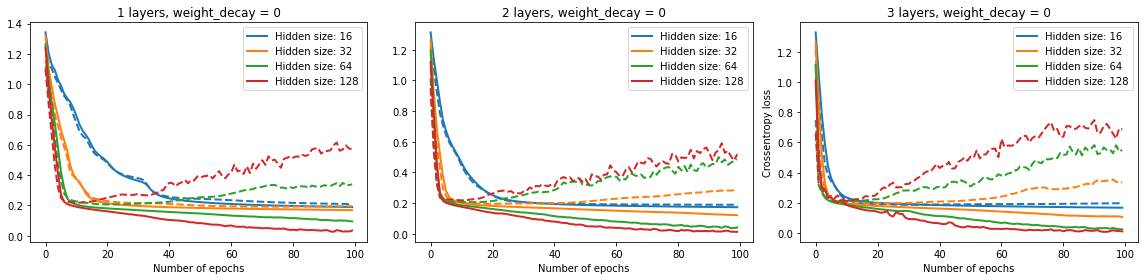

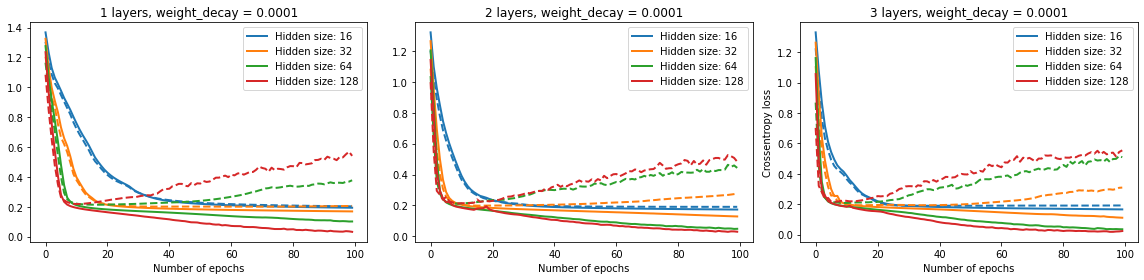

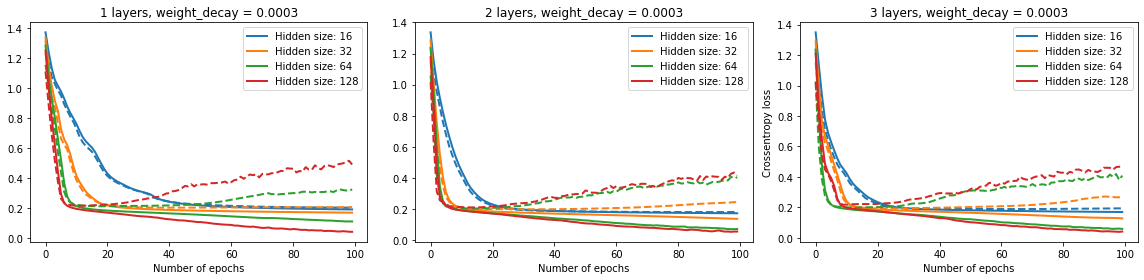

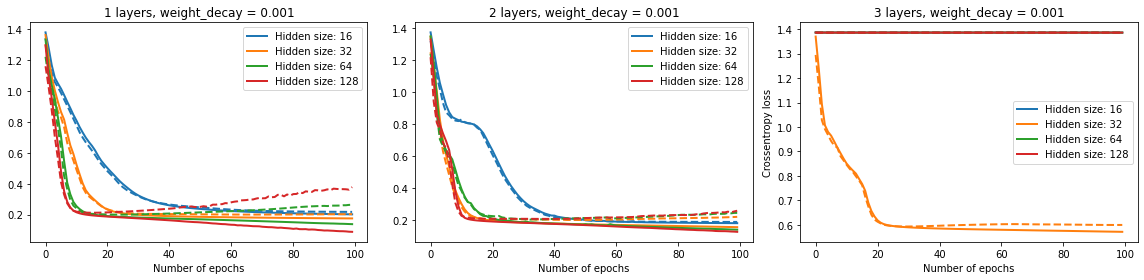

In [59]:
weight_decays = [0, 0.0001, 0.0003, 0.001]
for wd in weight_decays:
    fig ,ax = plt.subplots(1,3, figsize=(16,4))
    for idx, layer_num in enumerate(layers):
        for i, hs in enumerate(hidden_sizes):
    #         for model in torch.load(f'models/seq2seq_qpsk_{layer_num}_{hs}.pt'):
    #             plt.plot(model['losses'], f'C{i}')
    #             plt.plot(model['val_losses'], f'C{i}--')
            losses = np.mean([model['losses'] for model in torch.load(f"models/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")], axis=0)
            val_losses = np.mean([model['val_losses'] for model in torch.load(f"models/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")], axis=0)
            ax[idx].plot(losses,  f'C{i}', linewidth=2)
            ax[idx].plot(val_losses,  f'C{i}--', linewidth=2)
            
        
            legend_elements = [Line2D([0], [0], color='C0', lw=2),
                        Line2D([0], [0], color='C1', lw=2),
                        Line2D([0], [0], color='C2', lw=2),
                        Line2D([0], [0], color='C3', lw=2)]
        
            ax[idx].legend(legend_elements, ('Hidden size: 16', 'Hidden size: 32', 'Hidden size: 64', 'Hidden size: 128'))
            
            ax[idx].set_title(f'{layer_num} layers, weight_decay = {wd}')
            ax[idx].set_xlabel('Number of epochs'); plt.ylabel('Crossentropy loss')
            ax[idx].grid()
        plt.tight_layout()

In [64]:
weight_decays = [0, 0.0001, 0.0003, 0.001, 0.003]
for wd in weight_decays:
    for layer_num in layers:
        for hs in hidden_sizes:
            print(f'evaling {layer_num}/{hs}')
            
            models = torch.load(f"models/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")
            
            test_results = []
            for model in models:
                encoder_state = model['encoder']
                decoder_state = model['decoder']

                encoder = EncoderRNN(hidden_size=hs, input_size=2, num_layers=layer_num, device = 'cuda' if gpu else 'cpu')
                decoder = DecoderRNN(hidden_size=hs, input_size=4, num_layers=layer_num, device = 'cuda' if gpu else 'cpu')

                encoder.load_state_dict(encoder_state)
                decoder.load_state_dict(decoder_state)

                accs = evaluate_model(encoder, decoder, snr_range=test_snr_range, num_examples=2048)

                test_result = {'accs': accs,
                                'snr_range': test_snr_range}
                
                test_results.append(test_result)
            
            torch.save(test_results, f"results/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")

evaling 1/16
evaling 1/32
evaling 1/64
evaling 1/128
evaling 2/16
evaling 2/32
evaling 2/64
evaling 2/128
evaling 3/16
evaling 3/32
evaling 3/64
evaling 3/128
evaling 1/16
evaling 1/32
evaling 1/64
evaling 1/128
evaling 2/16
evaling 2/32
evaling 2/64
evaling 2/128
evaling 3/16
evaling 3/32
evaling 3/64
evaling 3/128
evaling 1/16
evaling 1/32
evaling 1/64
evaling 1/128
evaling 2/16
evaling 2/32
evaling 2/64
evaling 2/128
evaling 3/16
evaling 3/32
evaling 3/64
evaling 3/128
evaling 1/16
evaling 1/32
evaling 1/64
evaling 1/128
evaling 2/16
evaling 2/32
evaling 2/64
evaling 2/128
evaling 3/16
evaling 3/32
evaling 3/64
evaling 3/128
evaling 1/16
evaling 1/32
evaling 1/64
evaling 1/128
evaling 2/16
evaling 2/32
evaling 2/64
evaling 2/128
evaling 3/16
evaling 3/32
evaling 3/64
evaling 3/128


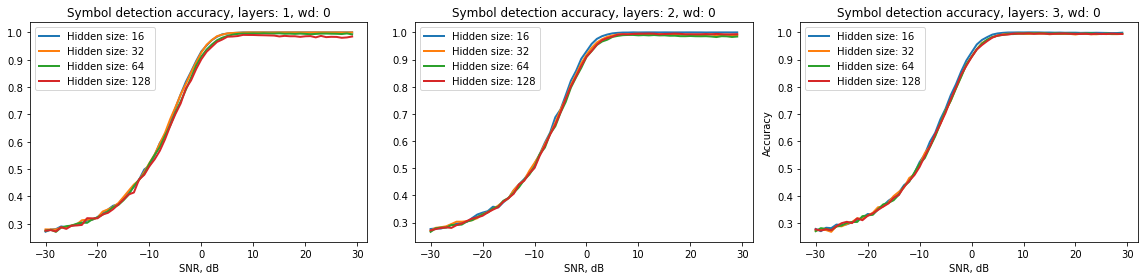

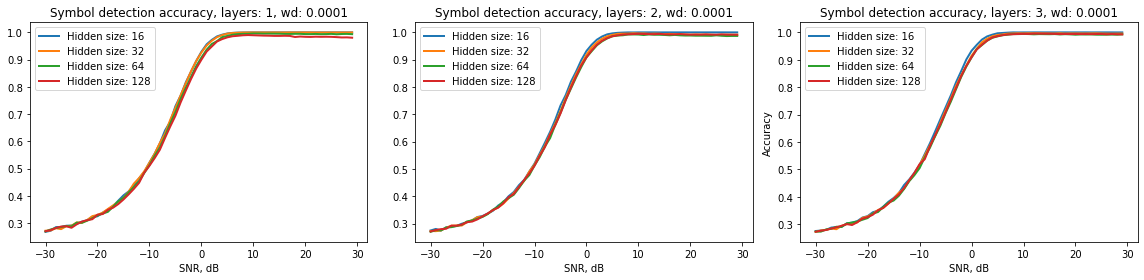

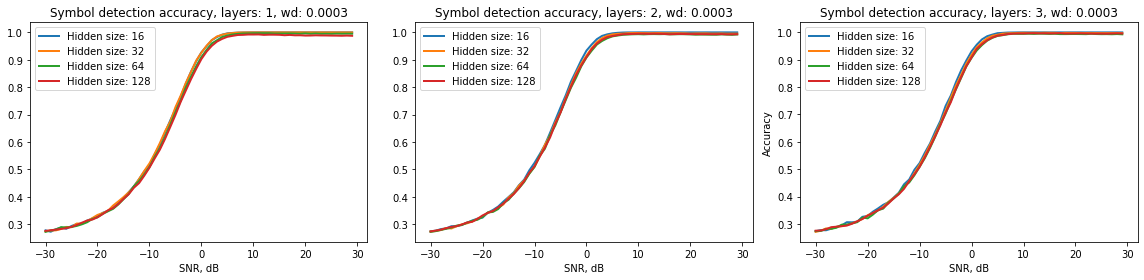

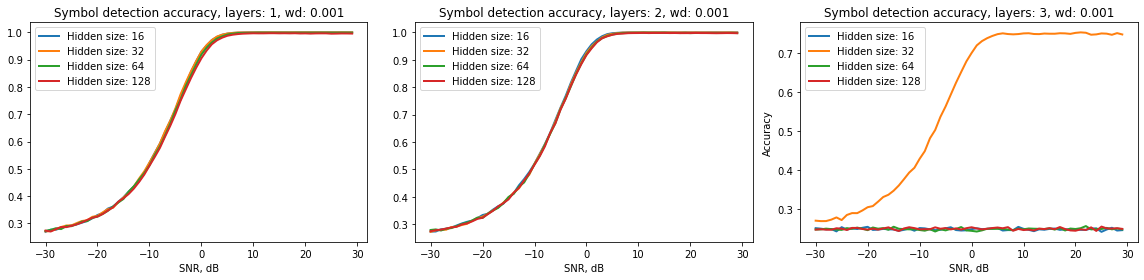

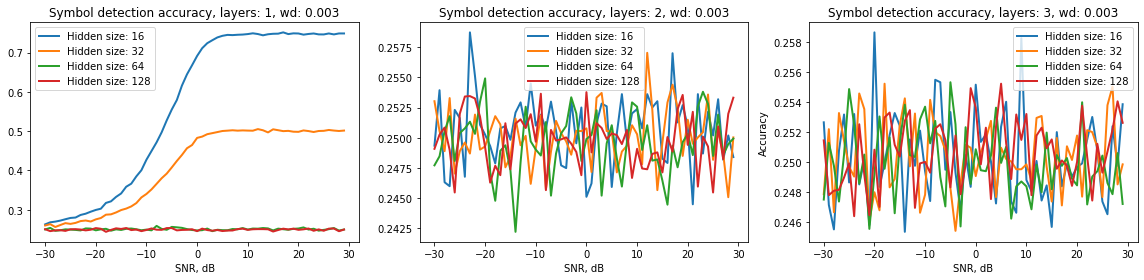

In [65]:
weight_decays = [0, 0.0001, 0.0003, 0.001, 0.003]
for wd in weight_decays:
    fig ,ax = plt.subplots(1,3, figsize=(16,4))
    for idx, layer_num in enumerate(layers):
        for i, hs in enumerate(hidden_sizes):
            accs = np.mean([model['accs'] for model in torch.load(f"results/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")], axis=0)
            snr_range = torch.load(f"results/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")[0]['snr_range']
            ax[idx].plot(snr_range, accs, f'C{i}', linewidth=2)
    #         accs = torch.load(f'results/seq2seq_qpsk_{layer_num}_{hs}.pt')['accs']
    #         snr_range = torch.load(f'results/seq2seq_qpsk_{layer_num}_{hs}.pt')['snr_range']
            ax[idx].grid()
            ax[idx].set_title(f'Symbol detection accuracy, layers: {layer_num}, wd: {wd}')
            ax[idx].legend(('Hidden size: 16', 'Hidden size: 32', 'Hidden size: 64', 'Hidden size: 128'))
            ax[idx].set_xlabel('SNR, dB'); plt.ylabel('Accuracy')
            plt.tight_layout()
    #     plt.savefig(f'figures/seq2seq_qpsk_accs_{layer_num}_layers_{training_config["num_epochs"]}_epochs.svg',
    #                 dpi=300, bbox_inches='tight')

In [2]:
def find_best_worst(results):
    best_acc = 0
    worst_acc = 100
    for idx, result in enumerate(results):
        mean_acc = np.mean(np.array(result['accs']))
        if mean_acc < worst_acc:
            worst_acc = mean_acc
            worst_idx = idx
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_idx = idx
    return best_idx, worst_idx

In [6]:
table = np.zeros([len(layers)*len(hidden_sizes)*len(weight_decays), 6])
j=0
for wd in weight_decays:
    for layer_num in layers:
        for i, hs in enumerate(hidden_sizes):
            results = torch.load(f"results/seq2seq_qpsk_{layer_num}_{hs}_wd_{wd}.pt")
            best_idx, worst_idx = find_best_worst(results)
            mean_acc = np.mean([model['accs'] for model in results])
            best_acc = np.mean(results[best_idx]['accs'])
            
            models = torch.load(f"models/seq2seq_qpsk_{layer_num}_{hs}_wd_{training_config['weight_decay']}.pt")
            best_val_loss = np.min(np.mean([model['val_losses'] for model in models], axis=0))
            
            table[j] = np.array([layer_num, hs, wd, best_val_loss, mean_acc*100, best_acc*100])
            j+=1

In [7]:
test_frame = pd.DataFrame(table, columns=['num layers', 'hidden size', 'wd', 'best loss', 'mean acc', 'best acc'])

In [8]:
test_frame['mean acc'].argmax()

32

In [9]:
test_frame = pd.DataFrame(table, columns=['num layers', 'hidden size', 'wd', 'best loss', 'mean acc', 'best acc'])
test_frame['num layers'] = test_frame['num layers'].astype(int)
test_frame['hidden size'] = test_frame['hidden size'].astype(int)
test_frame['best loss'] = test_frame['best loss'].map('{:,.3}'.format)
test_frame['mean acc'] = test_frame['mean acc'].map('{:,.4}'.format)
test_frame['best acc'] = test_frame['best acc'].map('{:,.4}'.format)
test_frame

,num layers,hidden size,wd,best loss,mean acc,best acc
0,1,16,0.0000,0.203,72.88,72.88
1,1,32,0.0000,0.201,72.96,72.96
2,1,64,0.0000,0.214,72.24,72.24
3,1,128,0.0000,0.218,71.61,71.61
4,2,16,0.0000,0.191,72.99,72.99
5,2,32,0.0000,0.199,72.4,72.4
6,2,64,0.0000,0.212,71.86,71.86
7,2,128,0.0000,0.214,72.18,72.18
8,3,16,0.0000,0.19,72.86,72.86
9,3,32,0.0000,0.194,72.3,72.3


So best performing model is 3 layers, 16 cell size, 0.0003 weight decay

In [13]:
test_frame.to_latex('qpsk_sweep.tex', index=False)